In [1]:
%load_ext autoreload
%autoreload 2
# imports

import pacsltk.pacs_util as pacs_util
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

pacs_util.prepare_matplotlib_cycler()

# To avoid type 3 fonts: http://phyletica.org/matplotlib-fonts/
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import parse_util

import os
import glob
from datetime import timedelta

import pacsltk
print(pacsltk.__version__)

0.2.0


In [2]:
# Config paths
EXP_CONFIG_NAME_DEFAULT = 'bench1_sleep_rand2_1000_200'
exp_config_name = os.getenv("EXP_CONFIG_NAME", EXP_CONFIG_NAME_DEFAULT)
exp_file = f"configs/{exp_config_name}.json"
overview_file_glob = f"results/{exp_config_name}/overview*.csv"
overview_file = glob.glob(overview_file_glob)[0]

print('config name:', exp_config_name)
print('overview file:', overview_file)
print('experiment file:', exp_file)

config name: bench1_sleep_rand2_1000_200
overview file: results/bench1_sleep_rand2_1000_200/overview_res-2021-02-27_16-47-11.csv
experiment file: configs/bench1_sleep_rand2_1000_200.json


In [3]:
# get overview
overview_df = pd.read_csv(overview_file, index_col=0, parse_dates=True)
overview_df.head(8)

,target,rps,res_name,request_func,workload_name,is_rps,exp_time_mins
0,1,1,res-2021-02-25_17-23-32,bench1_sleep_rand2_1000_200,bench1,False,60
1,1,2,res-2021-02-25_18-24-16,bench1_sleep_rand2_1000_200,bench1,False,60
2,1,3,res-2021-02-25_19-24-47,bench1_sleep_rand2_1000_200,bench1,False,60
3,1,5,res-2021-02-25_20-25-14,bench1_sleep_rand2_1000_200,bench1,False,60
4,1,7,res-2021-02-25_21-25-36,bench1_sleep_rand2_1000_200,bench1,False,60
5,1,10,res-2021-02-25_22-25-54,bench1_sleep_rand2_1000_200,bench1,False,60
6,1,15,res-2021-02-25_23-26-10,bench1_sleep_rand2_1000_200,bench1,False,60
7,1,20,res-2021-02-26_00-26-27,bench1_sleep_rand2_1000_200,bench1,False,60


In [10]:
# merge results of logger results
df_logger_merged = pd.DataFrame()
df_reqs_merged = pd.DataFrame()
for res_name in tqdm(overview_df['res_name']):
    res_logger_file = f"results/{exp_config_name}/{res_name}_logger.csv"
    df = parse_util.parse_logger_file(res_logger_file)
    df_logger_merged = df_logger_merged.append(df)

    res_reqs_file = f"results/{exp_config_name}/{res_name}_reqs.csv"
    df_req = parse_util.parse_reqs_file(res_reqs_file)
    df_reqs_merged = df_reqs_merged.append(df_req)

df_logger_merged_lon = df_logger_merged.groupby('lambda_over_n').mean().filter(
    ['conc_window_average', 'current_cc']
)
df_reqs_merged_lon = df_reqs_merged.groupby('lambda_over_n').mean().filter(
    ['client_elapsed_time', 'start_conc']
).rename(columns={
    'client_elapsed_time': 'resp_time_avg',
})

  0%|          | 0/48 [00:00<?, ?it/s]

In [11]:
df_logger_merged_lon.head()

,conc_window_average,current_cc
lambda_over_n,,
0.333333,0.666017,0.364539
0.400000,0.746827,0.513158
0.428571,0.729010,0.514677
0.454545,0.825572,0.402597
0.500000,0.731586,0.606962


In [12]:
df_reqs_merged_lon.head()

,resp_time_avg,start_conc
lambda_over_n,,
0.333333,1.197901,2.211538
0.400000,1.211112,3.416149
0.428571,1.210492,4.681716
0.454545,1.177768,5.080000
0.500000,1.238483,4.254602


# Concurrency Value Analysis By $\lambda/N$

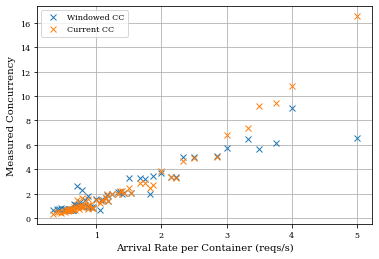

In [13]:
# let's analyze the relationship between conc_window_average and lambda_over_n
plt.plot(df_logger_merged_lon.index, df_logger_merged_lon['conc_window_average'], 'x', label='Windowed CC')
plt.plot(df_logger_merged_lon.index, df_logger_merged_lon['current_cc'], 'x', label='Current CC')
plt.xlabel('Arrival Rate per Container (reqs/s)')
plt.ylabel('Measured Concurrency')
plt.legend()
plt.grid(True)

In [25]:
# imports
from sklearn.pipeline import Pipeline
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [61]:
class CCTransformer():
    def __init__(self, columns=None, ):
        self.columns = columns
        # default columns if not provided
        if columns is None:
            self.columns = ['lon', 'cc']
        
    # here you define the operation it should perform
    def transform(self, X, y=None, **fit_params):
        cpy_df = X[self.columns].copy()
        cpy_df['lon2'] = cpy_df['lon'] ** 2
        return cpy_df

    # just return self
    def fit(self, X, y=None, **fit_params):
        return self

cc_pipe = Pipeline([
    ('cctransformer', CCTransformer())
])

df_cc = df_logger_merged_lon.reset_index().rename(columns={
    'lambda_over_n': 'lon',
    'current_cc': 'cc',
})


def cc_model_get_x_y(df_cc_orig):
    df_cc = cc_pipe.fit_transform(df_cc_orig)
    X = df_cc[['lon', 'lon2']].values
    y = df_cc['cc'].values
    return X, y

def cc_model_train(df_cc):
    X,y = cc_model_get_x_y(df_cc)
    # no intercept might be better because when lambda over n is zero, conc is zero
    regr = linear_model.LinearRegression(fit_intercept=False)
    # Train the model using the training sets
    regr.fit(X, y)
    # get estimate for goodness of fit
    yhat = regr.predict(X)
    print('MSE:', mean_squared_error(y, yhat))
    print('R2:', r2_score(y, yhat))
    return regr

def get_linear_model_params(regr):
    # get model params
    model_params = [regr.intercept_] + list(regr.coef_)
    return model_params

MSE: 0.10046879523748065
R2: 0.9875286382054725
Model Params: [0.0, 0.7587030452370006, 0.48814170860140793]


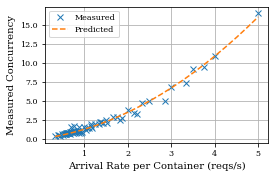

In [66]:
plt.figure(figsize=(4,2.5))
cc_regr = cc_model_train(df_cc)
print("Model Params:", get_linear_model_params(cc_regr))

plt_x = np.linspace(df_cc['lon'].min(), df_cc['lon'].max(), 20)
plt_df = pd.DataFrame(data={ 'lon': plt_x, 'cc': None })
plt_df = cc_pipe.fit_transform(plt_df)
test_X, test_Y = cc_model_get_x_y(plt_df)
plt_y = cc_regr.predict(test_X)

plt.plot(df_cc['lon'], df_cc['cc'], 'x', label="Measured")
plt.plot(plt_x, plt_y, label="Predicted")
plt.xlabel('Arrival Rate per Container (reqs/s)')
plt.ylabel('Measured Concurrency')
plt.legend()
plt.grid(True)
parse_util.tmp_fig_save('cc_vs_lambda_over_n_regression', exp_config_name)